# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: Linear GAN with MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202111

In [25]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import sys
import torchvision
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from torch.utils.data import DataLoader,Subset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [31]:
# import dataset (comes with colab!)
cdata =  torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [32]:
transform = T.Compose([ T.ToTensor(),
                        T.Resize( 64),
                        T.Normalize( .5,.5),
                       ])

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

classes2keep = [ 'Trouser','Sneaker','Pullover' ]

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = torch.Tensor()
for i in range(len(classes2keep)):
  classidx = cdata.classes.index(classes2keep[i])
  images = torch.cat( (images,torch.where(cdata.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes2keep[i]} (index {classidx})')

print('\nTensor data:')
print(images.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10 classes

Data size:
torch.Size([60000, 28, 28])
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)

Tensor data:
torch.Size([18000])


In [33]:
# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images)
data_loader = DataLoader(cdata,sampler=sampler,batch_size=batchsize,drop_last=True)

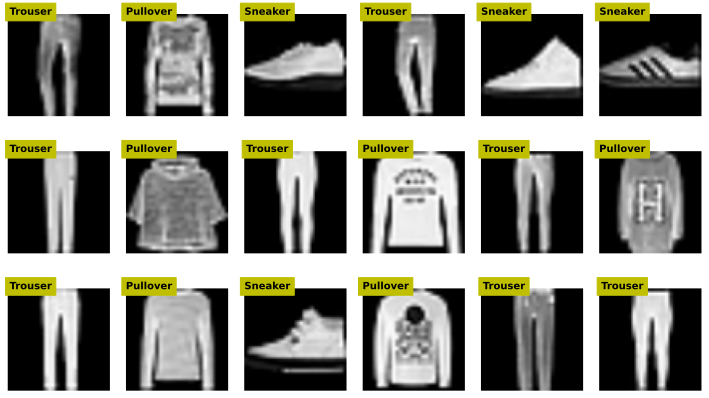

In [35]:
# view some images
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = cdata.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [36]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


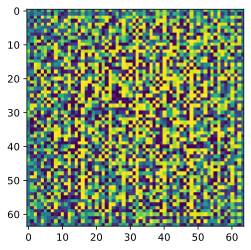

In [37]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

# Train the models!

In [39]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [ ]:
# number of epochs (expressed in number of batches)
num_epochs = int(2500/len(data_loader))

losses  = []
disDecs = []

for epochi in range(num_epochs):

  for data,_ in data_loader:
    
    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])
    
    d1 = torch.mean((pred_real>.5).float()).detach()
    d2 = torch.mean((pred_fake>.5).float()).detach()
    disDecs.append([d1,d2])


  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 1/13

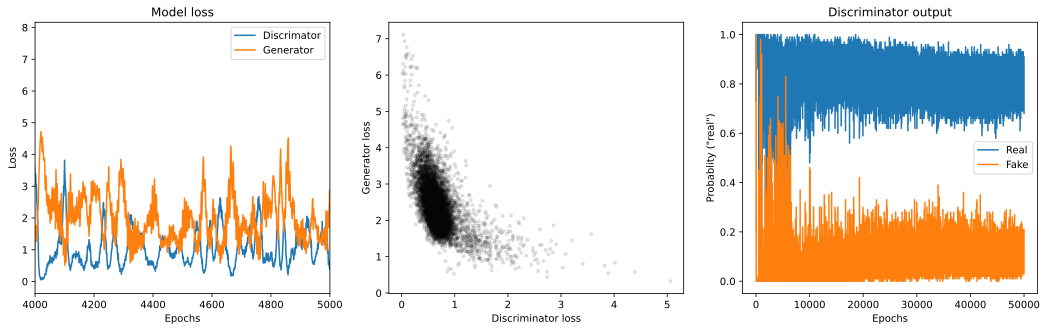

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some fake digits!

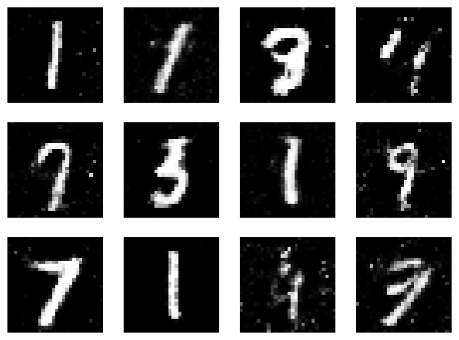

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

# Additional explorations

In [ ]:
# 1) I tried adding batch normalization to the models, but the results weren't that nice. Can you guess why? Try adding
#    batchnorm after each layer (except the output) and observe the effects. Can you explain why the results are the
#    way they are? (Note: batchnorm becomes important in deeper CNN GANs.)
# 
# 2) Re-running the same code to show the fake images returns different digits each time. Fix PyTorch's random seed so 
#    that the random numbers are identical each time you run the code. Are the images still different on multiple runs?
# 
# 3) To see how the generator is progressing, you can create some images during training. Here's what to do: (1) put the
#    image-generation code above inside a function. (2) Modify that function so that the figure is saved to a file.
#    (3) Modify the training function so that it calls the plotting function every 5000 epochs (or whatever resolution
#    you want). Then you can see how the images look more like digits as the generator model learns!
# 
# 4) GANs can be quite sensitive to the learning rate, because you are training two different but interacting networks
#    at the same time. Usually a good strategy is to have a very small learning rate and train for a long time. But don't
#    take my advice -- try a much larger learning rate for a shorter period of time, and see what happens!
# 